# Hands-on Machine Learning with Scikit-learn and Tensorflow
## 02 End to end Machine Learning project

This jupyter notebook is just a recitation of the first project in the book [Hands-on Machine Learning with Scikit-Learn and TensorFlow](https://github.com/ageron/handson-ml). I just add custom notes for my own comprehension. But all the credits goes to __Aurélien Géron__. <br>
You can check the official notebook : https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb.

## Brief
_Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts._

### Imports

In [1]:
import os
import tarfile
from six.moves import urllib
import hashlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

### Constants

In [2]:
# good practices
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

### Download the data

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
fetch_housing_data()
housing = load_housing_data()

### The data structure

In [6]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

### Find categorical attribute

In [9]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Visualize data

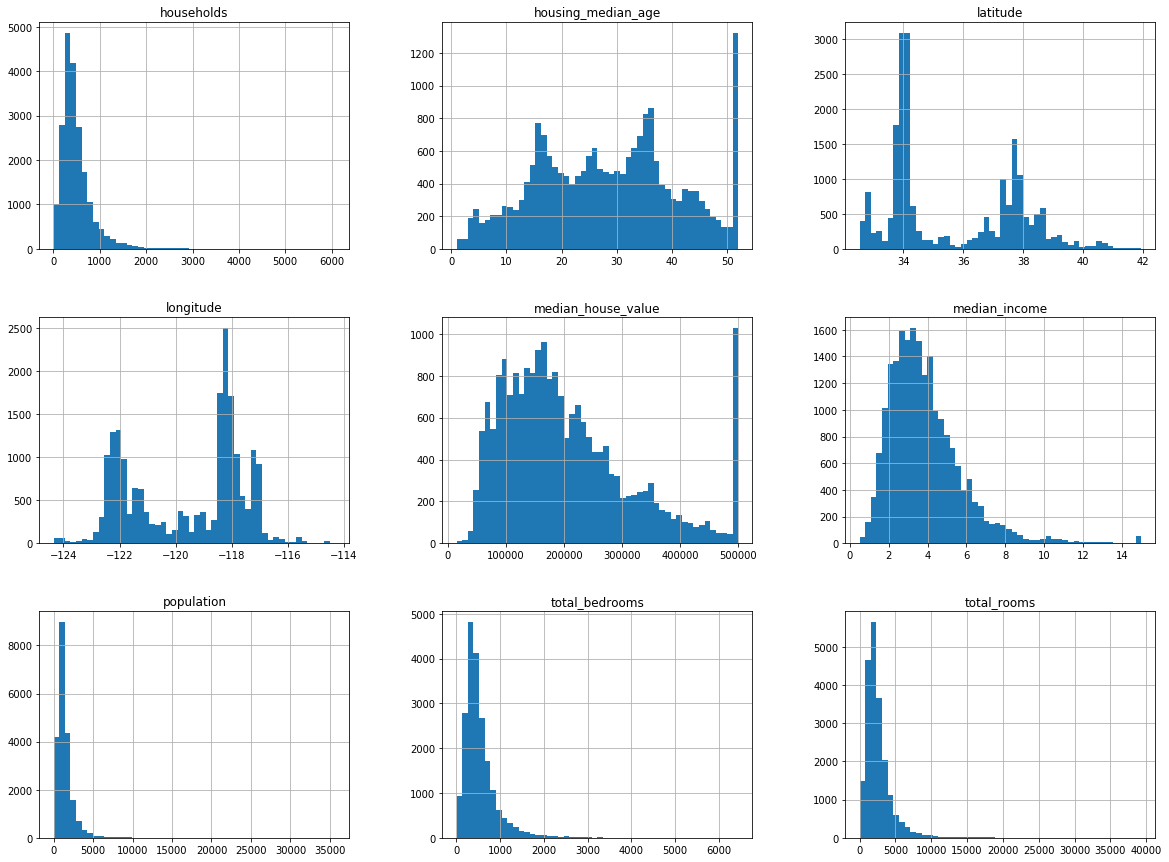

In [10]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Create a test set
I find the part of creating a test dataset very useful. I encourage you to read this part in the book (page 77).
#### Why we split the dataset ?
___
_"It may sound strange to voluntarily set aside part of the data at this stage. After all, you have only taken a
quick glance at the data, and surely you should learn a whole lot more about it before you decide what
algorithms to use, right?
This is true, but your brain is __an amazing pattern detection system__, which means
that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly
interesting pattern in the test data that leads you to select a particular kind of Machine Learning model."_ <br>
___

#### Good practice
The better solution to create a test set is to use a __unique and immuable identifier__ for each instance. Also we can compute a hash on each instance's identifier, keep only the last byte of the hash and put the instance in the test set if this value is lower or equal to 51 (~20% of 256). <br>
__This ensures that the test set will remain consistent across multiple runs, even if you
refresh the dataset.__ <br>
In our example, Longitude and Latitude are guaranteed stable, so we could combine them into an ID.

In [11]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [12]:
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']

In [14]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

#### Go further
Here we have considered purely random sampling methods. __Aurélien__ said that it is generally fine if our dataset is large enough. <br>
But in fact, we introduce a biais in our split.
#### Does each instance have a unique couple Longitude/Latitude ?

In [15]:
len(housing[housing.duplicated(subset=['longitude', 'latitude'], keep=False)])

12403

In [16]:
housing[housing.duplicated(subset=['longitude', 'latitude'], keep=False)].sort_values(by=['longitude', 'latitude']).head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2553    -124.18     40.78                37.0       1453.0           293.0   
2554    -124.18     40.78                33.0       1076.0           222.0   
2555    -124.18     40.78                34.0       1592.0           364.0   
2547    -124.18     40.79                39.0       1836.0           352.0   
2548    -124.18     40.79                40.0       1398.0           311.0   

      population  households  median_income  median_house_value  \
2553       867.0       310.0         2.5536             70200.0   
2554       656.0       236.0         2.5096             72200.0   
2555       950.0       317.0         2.1607             67000.0   
2547       883.0       337.0         1.7450             70500.0   
2548       788.0       279.0         1.4668             64600.0   

     ocean_proximity  
2553      NEAR OCEAN  
2554      NEAR OCEAN  
2555      NEAR OCEAN  
2547      NEAR OCEAN  
2548      NEAR OCEAN

No ! We have different instances that have a same longitude/latitude couple ! Same couple will be in the same set (train or test). <br>
So we have introdious a biais !
#### Solution
We can add features to find a unique identifier.

In [17]:
len(housing[housing.duplicated(subset=[
    'longitude','latitude','housing_median_age'
], keep=False)])

2345

In [18]:
len(housing[housing.duplicated(subset=[
    'longitude','latitude','housing_median_age', 'total_rooms'
], keep=False)])

2

In [19]:
len(housing[housing.duplicated(subset=[
    'longitude','latitude','housing_median_age', 'total_rooms', 'total_bedrooms'
], keep=False)])

0

I think with this features : longitude, latitude, housing_median_age, total_rooms and total_bedrooms, we really have an unique identifier. We can hash each instance and split it to have a train and test set without biais. <br>
_Note : If you provide more examples to dataset in the future, we need to be sure of the difference between each instances. Maybe we need to take all features._ <br>
__If you are reading this jupyter notebook, I will appreciate if you help me to be more certain about it__

#### Stratified sampling

In [20]:
housing["income_cat"] = np.ceil(housing.median_income / 1.5)
housing['income_cat'].where(housing.income_cat < 5, 5.0, inplace=True)

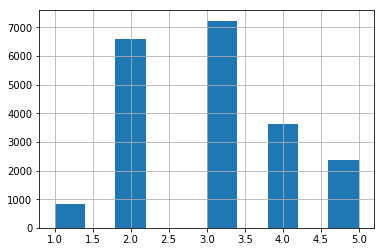

In [21]:
housing["income_cat"].hist()

It is important to have a sufficient number of instances in your dataset for each stratum for avoid bias.

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
housing.income_cat.value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [24]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

### Discover and Visualize the Data to Gain Insights

In [25]:
housing = strat_train_set.copy()

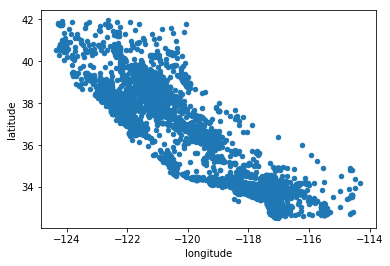

In [26]:
housing.plot(kind='scatter', x='longitude', y='latitude')

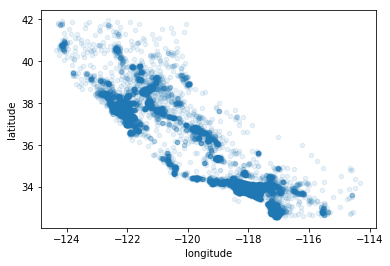

In [27]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

#### Housing prices

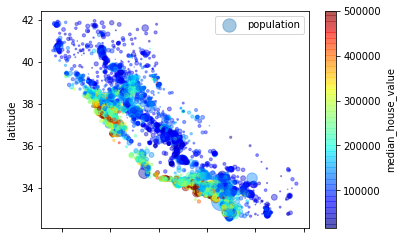

In [28]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing.population/100, label='population',
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
            )
plt.legend()

### Looking for correlations

In [29]:
corr_matrix = housing.corr()

In [30]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Warning : Only linear correlations

In [31]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1115bdc50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1cce2550>]], dtype=object)

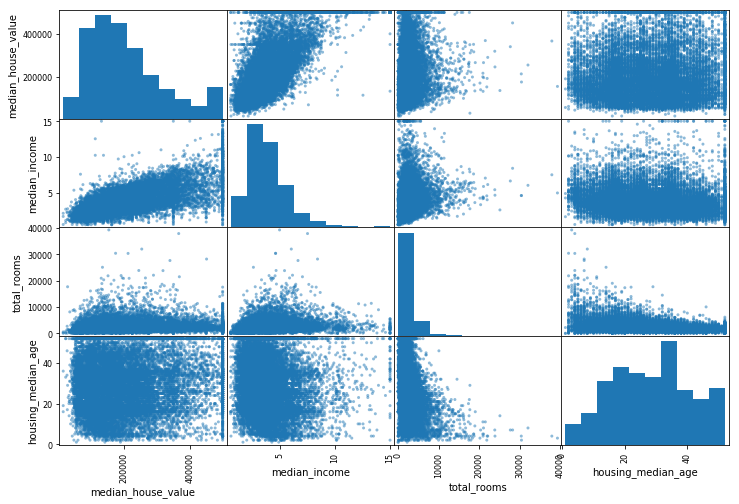

In [32]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

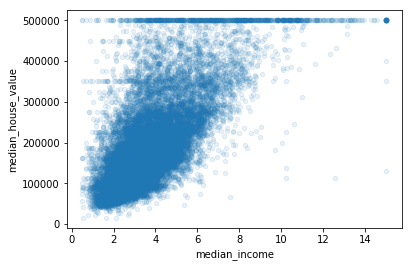

In [33]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

### Experimenting with attribute combinations

In [34]:
housing.rooms_per_household = housing.total_rooms / housing.households
housing.bedrooms_per_household = housing.total_bedrooms / housing.households
housing.population_per_household = housing.population / housing.households

In [35]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

### Prepare the data for Machine Learning

In [36]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set.median_house_value.copy()

#### Data cleaning

In [37]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

In [38]:
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [39]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [40]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [41]:
X = imputer.transform(housing_num)

#### Handling Text and Categorical Atrributes

In [42]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing.ocean_proximity
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [43]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)

Warning : ML algorithms will assume that two nearby values are more similar than two distant values.

In [44]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [45]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [46]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

#### Custom transformers

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        return np.c_[X, rooms_per_household, population_per_household]

In [48]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

#### Transformation Pipelines

In [49]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

In [50]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [51]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [52]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [53]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [54]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

In [55]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [56]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [57]:
housing_prepared.shape

(16512, 16)

### Select and train a  model
#### Linear Regression

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [60]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [61]:
lin_reg.predict(some_data_prepared)

array([ 210644.60459286,  317768.80697211,  210956.43331178,
         59218.98886849,  189747.55849879])

In [62]:
list(some_labels)

[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]

In [63]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

This is clearly a case of underfitting. When this happens it can mean that the feature does'nt provide enough information to make a good prediction or that the model is not powerful enough.

#### Decision Tree

In [64]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [65]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Overfit !

#### Better evaluation using cross-validation

In [66]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)

In [67]:
rmse_scores

array([ 69349.1186719 ,  67236.94040038,  68838.80850612,  68727.35675113,
        70027.03924027,  73636.44486609,  70136.55976927,  70821.15361555,
        76721.36995201,  71302.68921947])

In [68]:
rmse_scores.mean()

70679.748099219578

In [69]:
rmse_scores.std()

2592.2340566505518

In [70]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [71]:
lin_rmse_scores.mean()

69052.461363450828

In [72]:
lin_rmse_scores.std()

2731.6740017983475

#### Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [74]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [75]:
forest_rmse_scores

array([ 52198.49960052,  50275.31176982,  52435.50670293,  53833.3191637 ,
        51967.57841609,  56759.04476057,  51248.21676177,  49422.85995186,
        55583.97705572,  53350.31866144])

In [76]:
forest_rmse_scores.mean()

52707.463284441132

In [77]:
forest_rmse_scores.std()

2146.7247825293653

#### Save Model

In [78]:
from sklearn.externals import joblib

In [79]:
joblib.dump(forest_reg, 'forest_reg.pkl')
forest_reg = joblib.load('forest_reg.pkl')

### Fine-Tune your Model
#### Grid Search

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [82]:
forest_reg = RandomForestRegressor()

In [83]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

In [84]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

- first dict : 3*4 combinations for n_estimators and max_features
- second dict : 2*3
- 18 combinations and train 5 times
- 18 * 5 = 90 rounds of training !

In [85]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [86]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [87]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64680.3757625 {'max_features': 2, 'n_estimators': 3}
55628.4643811 {'max_features': 2, 'n_estimators': 10}
52904.383414 {'max_features': 2, 'n_estimators': 30}
60508.5626807 {'max_features': 4, 'n_estimators': 3}
52824.6502187 {'max_features': 4, 'n_estimators': 10}
50467.0956996 {'max_features': 4, 'n_estimators': 30}
59523.5102715 {'max_features': 6, 'n_estimators': 3}
52265.4253786 {'max_features': 6, 'n_estimators': 10}
49875.1316741 {'max_features': 6, 'n_estimators': 30}
58396.3501845 {'max_features': 8, 'n_estimators': 3}
52825.6266315 {'max_features': 8, 'n_estimators': 10}
50426.8366341 {'max_features': 8, 'n_estimators': 30}
63061.505301 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54489.2378592 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60193.1425818 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52540.1186418 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58354.1198466 {'bootstrap': False, 'max_features': 4, 'n_estimat

#### Analyze the best models and their errors

In [88]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [89]:
feature_importances

array([  7.28855550e-02,   6.68499740e-02,   4.28901812e-02,
         1.76975846e-02,   1.72964434e-02,   1.79750447e-02,
         1.64903251e-02,   3.16540787e-01,   6.82513151e-02,
         1.04852239e-01,   8.43066164e-02,   9.37636808e-03,
         1.52736451e-01,   7.16569439e-05,   5.05410277e-03,
         6.72535489e-03])

In [90]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31654078742427549, 'median_income'),
 (0.15273645117649207, 'INLAND'),
 (0.10485223919881292, 'pop_per_hhold'),
 (0.084306616439132398, 'bedrooms_per_room'),
 (0.072885554994080851, 'longitude'),
 (0.068251315121949777, 'rooms_per_hhold'),
 (0.066849973960770026, 'latitude'),
 (0.04289018115591467, 'housing_median_age'),
 (0.017975044703838358, 'population'),
 (0.017697584617105633, 'total_rooms'),
 (0.017296443431206156, 'total_bedrooms'),
 (0.016490325091650371, 'households'),
 (0.009376368077853298, '<1H OCEAN'),
 (0.0067253548948613797, 'NEAR OCEAN'),
 (0.0050541027681823454, 'NEAR BAY'),
 (7.1656943874318812e-05, 'ISLAND')]

### Evaluate your system on the test set

In [91]:
final_model = grid_search.best_estimator_

In [92]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [93]:
X_test_prepared = full_pipeline.transform(X_test)

In [94]:
final_predictions = final_model.predict(X_test_prepared)

In [95]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [96]:
final_rmse

48452.228629786856

### Exercises

#### Support Vector Machine

In [97]:
dfrom sklearn.svm import SVR

In [110]:
param_grid = [
    {'kernel': ['linear'], 'C': [1, 10, 100]},
    {'kernel': ['rbf'], 'C': [1, 10, 100], 'gamma': [1, 10, 100]},
]

In [111]:
svm_model = SVR()

In [112]:
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error')

In [113]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 100]}, {'kernel': ['rbf'], 'C': [1, 10, 100], 'gamma': [1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [114]:
grid_search.best_estimator_

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [117]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

112571.79521 {'C': 1, 'kernel': 'linear'}
84654.0893002 {'C': 10, 'kernel': 'linear'}
71603.1219648 {'C': 100, 'kernel': 'linear'}
118886.400957 {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
118922.400123 {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
118923.000798 {'C': 1, 'gamma': 100, 'kernel': 'rbf'}
118595.337845 {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
118917.314281 {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
118923.186716 {'C': 10, 'gamma': 100, 'kernel': 'rbf'}
115842.431404 {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
118888.286054 {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
118925.075152 {'C': 100, 'gamma': 100, 'kernel': 'rbf'}
